##  模型评估
本章节以多项式拟合为例来理解**模型复杂度**和**训练数据集大小**对欠拟和过拟合的影响。

### 1.1 生成数据集
按下式生成$y$：
$$
y = 1.2x - 3.4x^2 + 5.6 x^3 + 5 + \epsilon,
$$
其中$\epsilon \sim \mathcal{N}(\mu=0, \sigma=0.01)$。

In [4]:
%matplotlib inline
import torch
import numpy as np

n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = true_w[0] * poly_features[:, 0] + \
         true_w[1] * poly_features[:, 1] + \
         true_w[2] * poly_features[:, 2] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

print(features[:2], '\n', poly_features[:2], '\n', labels[:2])
print(features.shape, poly_features.shape, labels.shape)

tensor([[-0.3183],
        [-0.9168]]) 
 tensor([[-0.3183,  0.1013, -0.0323],
        [-0.9168,  0.8405, -0.7706]]) 
 tensor([ 4.0933, -3.2603])
torch.Size([200, 1]) torch.Size([200, 3]) torch.Size([200])


### 1.2 定义图表绘制函数

In [2]:
import my_utils

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    my_utils.use_svg_display()
    my_utils.set_figsize(figsize)
    my_utils.plt.xlabel(x_label)
    my_utils.plt.ylabel(y_label)
    my_utils.plt.semilogy(x_vals, y_vals)      # 绘制(x, log(y))
    if x2_vals and y2_vals:
        my_utils.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        my_utils.plt.legend(legend)

### 1.3 定义模型训练过程
将多项式拟合看成线性模型，基分别为$[x, x^2, x^3]$，因此权重$\vec{w} \in \mathbb{R}^3$，偏置$b \in \mathbb{R}$。

In [3]:
num_epochs = 100
loss = torch.nn.MSELoss()           # 回归问题使用均方误差

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # torch.nn.Linear会自动初始化参数
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    # 构造数据集并取得batch
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        # 输出每轮训练后在训练集和测试集上的loss并绘图
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epoch', 'loss', 
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('trained weight:', net.weight.data)
    print('trained bias:', net.bias.data)
    print('true weight:', true_w)
    print('true bias:', true_b)

### 1.4 测试模型复杂度的影响

#### 1.4.1 使用三阶多项式拟合

final epoch: train loss 0.00010045091767096892 test loss 0.00011642503523034975
trained weight: tensor([[ 1.2032, -3.4008,  5.5992]])
trained bias: tensor([5.0013])
true weight: [1.2, -3.4, 5.6]
true bias: 5


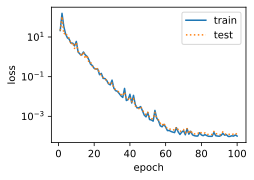

In [4]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

#### 1.4.2 使用一阶多项式拟合
欠拟合：模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。

final epoch: train loss 294.0723571777344 test loss 193.03265380859375
trained weight: tensor([[20.4907]])
trained bias: tensor([3.4520])
true weight: [1.2, -3.4, 5.6]
true bias: 5


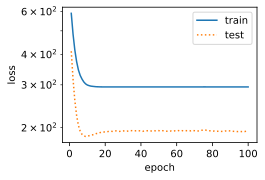

In [5]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

### 1.5 测试训练数据集大小的影响
过拟合：尽管训练误差较低，但是测试数据集上的误差却很高。

final epoch: train loss 0.48656755685806274 test loss 524.1360473632812
trained weight: tensor([[0.5267, 0.3507, 0.2616]])
trained bias: tensor([4.1087])
true weight: [1.2, -3.4, 5.6]
true bias: 5


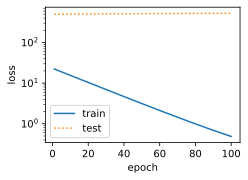

In [6]:
num_epochs = 100
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], 
             labels[0:2], labels[n_train:])